## Physics Informed Neural Networks to Approximate Solution of PDEs

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

# Basic theory and problem setup
Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$


with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0,
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto \mathbb{R}$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   
        
      
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



# Your task: Solve the $1D$ heat equation using PINNs

You will have to implement the following

*  `NNAnsatz` a neural net approximator for the solution of the heat equation.
*   Missing functionality in the `PINNTrainer`, namely:
    *   `PINNTrainer.compute_pde_residual` to compute the PDE loss on your predictions.
    *   `PINNTrainer.compute_loss` to aggregate all the residuals into a single weighted loss.

Use `torch.autograd.grad` to compute gradients, second derivatives -- some basic examples can be found [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). Make sure the gradients you compute are attached to the computational graph so that you can backpropagate through them.


Follow the `TODOs`.












In [72]:
class NNAnsatz(torch.nn.Module):
  def __init__(self,
               input_dimension,
               output_dimension,
               n_hidden_layers,
               hidden_size):
    super().__init__()
    # TODO: Setup your layers.
    self.layers = []
    for _ in range(n_hidden_layers):
      self.layers.append(torch.nn.Linear(input_dimension, hidden_size))
      self.layers.append(torch.nn.ReLU())
      input_dimension = hidden_size

    self.layers.append(torch.nn.Linear(input_dimension, output_dimension))

    self.model = torch.nn.Sequential(*self.layers)

  def forward(self, x):
    # TODO: Do a forward pass on `x`.
    return self.model(x)

In [73]:
class PINNTrainer:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t, x) in [0,0.1] x [-1,1]
        self.domain_extrema = torch.tensor([[0, 0.6],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        # TODO: Write the `NNAnsatz` class to be a feed-forward neural net
        # that you'll train to approximate your solution.
        self.approximate_solution = NNAnsatz(
            input_dimension=2, # (t, x)
            output_dimension=1, # => u(t, x)
            n_hidden_layers=4,
            hidden_size=20
        )


        # TODO: Setup optimizer.
        self.optimizer = torch.optim.Adam(self.approximate_solution.parameters())
        # self.optimizer = torch.optim.LBFGS(self.approximate_solution.parameters(),
        #                       lr=float(0.5),
        #                       max_iter=50000,
        #                       max_eval=50000,
        #                       history_size=150,
        #                       line_search_fn="strong_wolfe",
        #                       tolerance_change=1.0 * np.finfo(float).eps)

        # Generator of Sobol sequences.
        self.soboleng = torch.quasirandom.SobolEngine(
            dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = (
            self.assemble_datasets())

    ############################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return (
            tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0])
             + self.domain_extrema[:, 0])

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    ############################################################################
    # Function returning the input-output tensor required to
    # assemble the training set S_tb corresponding to the temporal boundary.
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to
    # assemble the training set S_sb corresponding to the spatial boundary.
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return (
            torch.cat([input_sb_0, input_sb_L], 0),
            torch.cat([output_sb_0, output_sb_L], 0)
        )

    # Function returning the input-output tensor required to assemble
    # the training set S_int corresponding to the interior domain
    # where the PDE is enforced.
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(
            torch.utils.data.TensorDataset(input_sb, output_sb),
            batch_size=2 * self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(
            torch.utils.data.TensorDataset(input_tb, output_tb),
            batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(
            torch.utils.data.TensorDataset(input_int, output_int),
            batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ############################################################################
    # Function to compute the terms required in the definition of
    # the `TEMPORAL` boundary residual.
    def eval_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition
    # of the `SPATIAL` boundary residual.
    def eval_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        # `grad` computes the gradient of a SCALAR function `L` w.r.t
        # some input (n x m) tensor  [[x1, y1], ...,[xn ,yn]] (here `m` = 2).
        #
        # it returns grad_L = [[dL/dx1, dL/dy1]...,[dL/dxn, dL/dyn]]
        # NOTO: pytorch considers a tensor [u1, u2,u3, ... ,un] a vector
        # whereas `sum_u = u1 + u2 + u3 + u4 + ... + un` as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2], ...]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un) /dxi ==
        #  d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi == dui / dxi.

        # TODO: compute `grad_u` w.r.t (t, x) (time + 1D space).
        grad_u = torch.autograd.grad(
            u.sum(), input_int, create_graph=True)[0]
    

        # TODO: Extract time and space derivative at all input points.
        grad_u_t = grad_u[:, 0]
        grad_u_x =  grad_u[:, 1]

        # TODO: Compute `grads` again across the spatial dimension --
        # here you should reuse something you just computed.
        grad_u_xx = torch.autograd.grad(
            grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]


        # Compute the residual term you're getting.
        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1,)

    # Function to compute the total loss (weighted sum of spatial boundary loss,
    # temporal boundary loss and interior loss).
    def compute_loss(
        self, inp_train_sb, u_train_sb,
        inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.eval_boundary_conditions(inp_train_sb)
        u_pred_tb = self.eval_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        # TODO: Compute interior PDE residual.
        r_int = self.compute_pde_residual(inp_train_int)

        # TOOD: Compute spatial boundary residual.
        r_sb = u_train_sb - u_pred_sb

        # TODO: Compute temporal boundary residual
        r_tb = u_train_tb - u_pred_tb


        # TODO: Compute losses based on these residuals.
        loss_sb = torch.mean(r_sb ** 2)
        loss_tb = torch.mean(r_tb ** 2)
        loss_int = torch.mean(r_int ** 2)

        loss_u = loss_sb + loss_tb
        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose:
           print(
               "Total loss: ",round(loss.item(), 4),
               "| PDE Loss: ", round(torch.log10(loss_u).item(), 4),
               "| Function Loss: ", round(torch.log10(loss_int).item(), 4)
          )

        return loss


    ############################################################################

    def fit(self, num_epochs, verbose):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose:
              print(f"{'#'*32} Epoch {epoch} {'#'*32}"),

            for j, inputs_and_outputs in enumerate(zip(self.training_set_sb,
                    self.training_set_tb,
                    self.training_set_int)):
                  (
                      (inp_train_sb, u_train_sb),
                      (inp_train_tb, u_train_tb),
                      (inp_train_int, u_train_int)
                  ) = inputs_and_outputs

                  def closure():
                    self.optimizer.zero_grad()
                    loss = self.compute_loss(
                        inp_train_sb,
                        u_train_sb,
                        inp_train_tb,
                        u_train_tb,
                        inp_train_int,
                        verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                  self.optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ############################################################################
    def plot(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(
            inputs[:, 1].detach(), inputs[:, 0].detach(),
            c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(
            inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(),
            cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (
            torch.mean((output - exact_output) ** 2) /
            torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


# Setting up the training data

Just familiarize yourself with how wo generate collocation points for the different types of residuals.

In [74]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi * x).

n_int = 256
n_sb = 64
n_tb = 64

pinn = PINNTrainer(n_int, n_sb, n_tb)

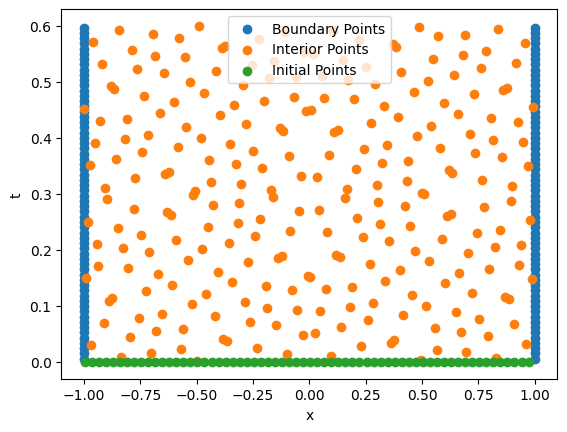

In [75]:
# Plot the input training points.
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.scatter(
    input_sb_[:, 1].detach().numpy(),
    input_sb_[:, 0].detach().numpy(),
    label="Boundary Points")
plt.scatter(
    input_int_[:, 1].detach().numpy(),
    input_int_[:, 0].detach().numpy(),
    label="Interior Points")
plt.scatter(
    input_tb_[:, 1].detach().numpy(),
    input_tb_[:, 0].detach().numpy(),
    label="Initial Points")

plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

# Training

Train your network and ensure your loss is low, and that your predictions are qualitatively similar to the true solution (plots should look similar).

################################ Epoch 0 ################################
Total loss:  0.338 | PDE Loss:  -0.7047 | Function Loss:  -0.6903
################################ Epoch 1 ################################
Total loss:  0.3273 | PDE Loss:  -0.7175 | Function Loss:  -0.6815
################################ Epoch 2 ################################
Total loss:  0.3162 | PDE Loss:  -0.7309 | Function Loss:  -0.6721
################################ Epoch 3 ################################
Total loss:  0.3044 | PDE Loss:  -0.7449 | Function Loss:  -0.6655
################################ Epoch 4 ################################
Total loss:  0.2918 | PDE Loss:  -0.7595 | Function Loss:  -0.6612
################################ Epoch 5 ################################
Total loss:  0.2787 | PDE Loss:  -0.775 | Function Loss:  -0.6558
################################ Epoch 6 ################################
Total loss:  0.2645 | PDE Loss:  -0.7913 | Function Loss:  -0.6541
###############

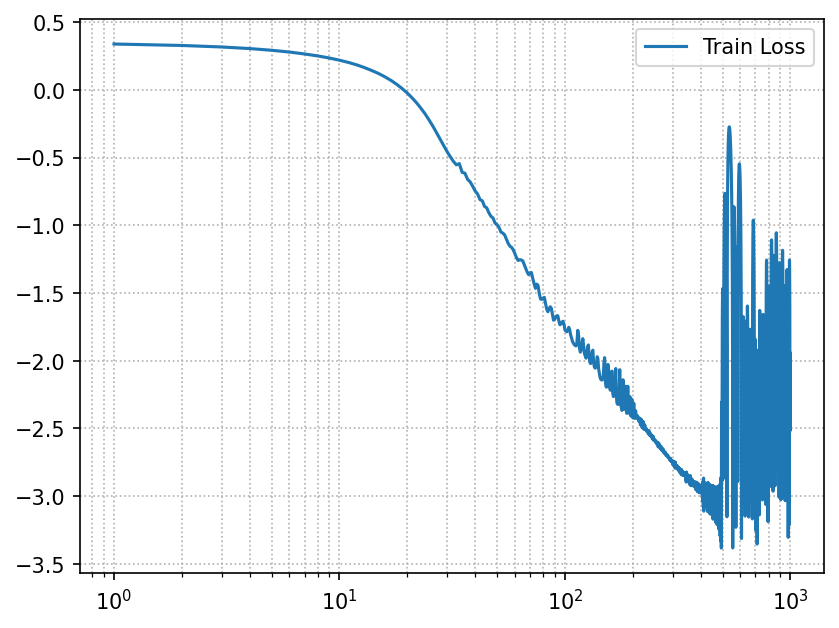

In [78]:
hist = pinn.fit(num_epochs=1000, verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

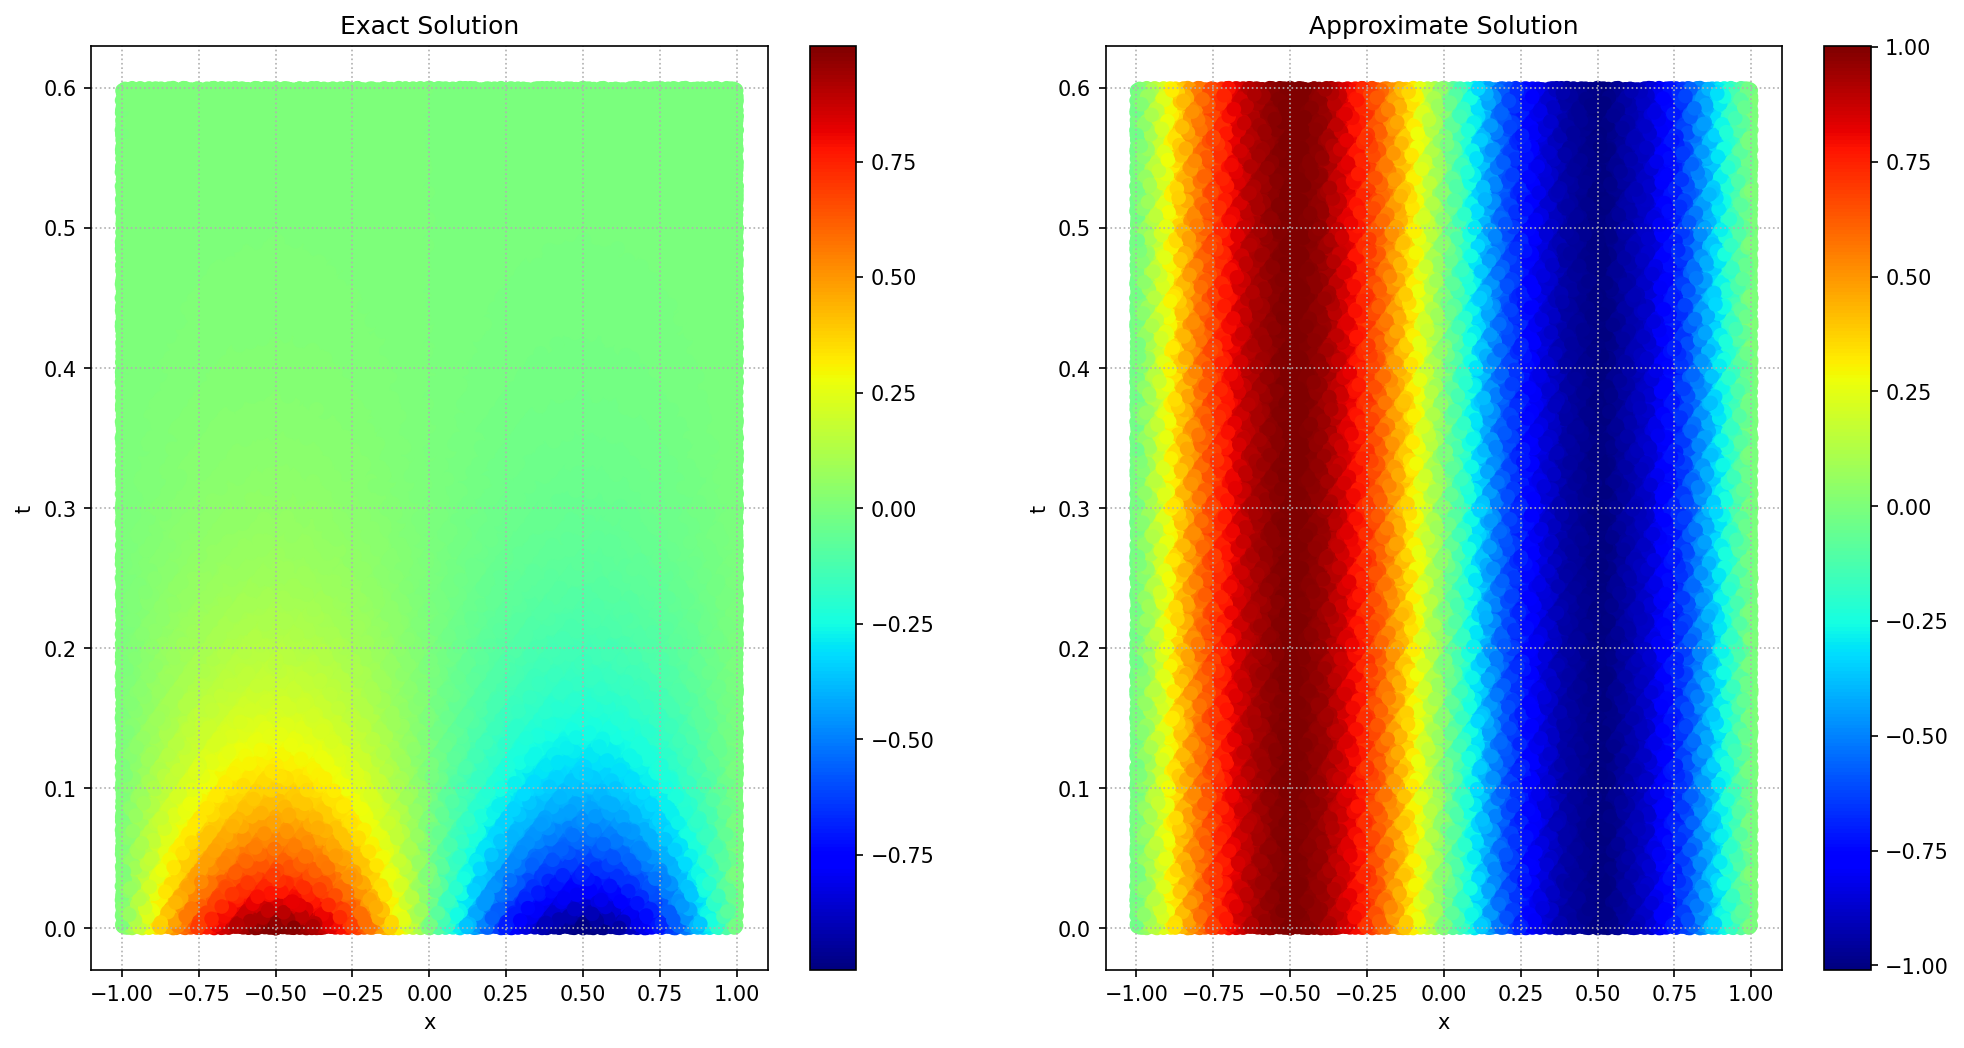

L2 Relative Error Norm:  293.99017333984375 %


In [79]:
pinn.plot()